In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50  # Or your specific ResNet variant
from PIL import Image
import numpy as np
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
import torch
from torchvision.models import resnet34

model = resnet34(pretrained=False)
try:
    model.load_state_dict(torch.load("plant_disease_model.pth", map_location=torch.device('cpu')))
    print("Model loaded successfully as resnet34!")
except RuntimeError as e:
    print(f"Error loading as resnet34: {e}")

from torchvision.models import resnet50

model = resnet50(pretrained=False)
try:
    model.load_state_dict(torch.load("plant_disease_model.pth", map_location=torch.device('cpu')))
    print("Model loaded successfully as resnet50!")
except RuntimeError as e:
    print(f"Error loading as resnet50: {e}")

C:\Users\rishi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rishi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Error loading as resnet34: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.

In [4]:
# Define the image transformations (must match your training transformations)
image_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
def generate_saliency_map(image_path, model, transform, target_class_index=None):
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).requires_grad_(True) # Add batch dimension and enable gradients

        output = model(img_tensor)

        if target_class_index is None:
            target_class_index = output.argmax(dim=1).item()

        target_output = output[0, target_class_index]
        target_output.backward() # Calculate gradients

        saliency_map = img_tensor.grad.abs().squeeze().cpu().numpy() # Absolute gradients, remove batch and channel dims
        saliency_map = np.transpose(saliency_map, (1, 2, 0)).mean(axis=2) # Average across color channels

        return saliency_map
    except Exception as e:
        print(f"Error generating saliency map: {e}")
        return None

In [14]:
# Example usage:
image_path = 'Screenshot 2025-04-10 132915.png' # Replace with the path to your image
target_class = 5 # Replace with the index of the disease class you want to visualize
saliency = generate_saliency_map(image_path, model, transform, target_class)

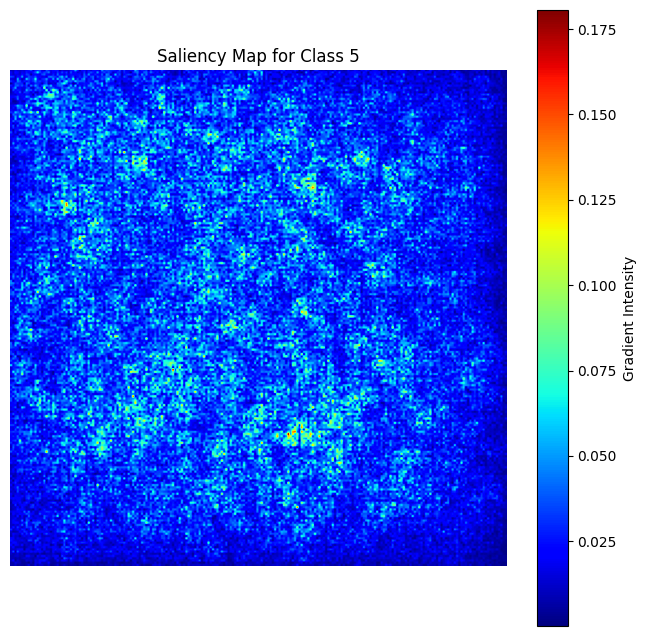

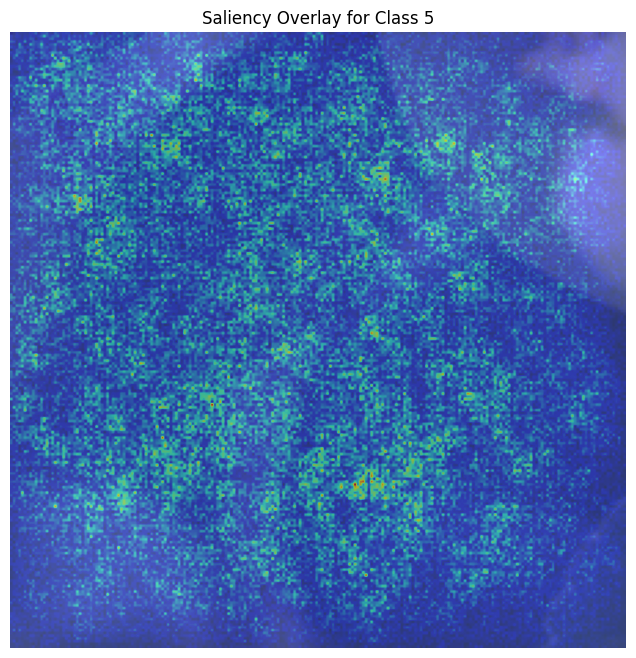

In [17]:
import matplotlib.pyplot as plt
if saliency is not None:
    # Visualize the saliency map
    plt.figure(figsize=(8, 8))
    plt.imshow(saliency, cmap='jet') # You can try other colormaps like 'hot', 'jet'
    plt.title(f'Saliency Map for Class {target_class}')
    plt.colorbar(label='Gradient Intensity')
    plt.axis('off')
    plt.show()

    # Optionally, overlay the saliency map on the original image
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img) / 255.0

    plt.figure(figsize=(8, 8))
    plt.imshow(img_np, alpha=0.7)
    plt.imshow(saliency, cmap='jet', alpha=0.5)
    plt.title(f'Saliency Overlay for Class {target_class}')
    plt.axis('off')
    plt.show()
    